In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [ ]:
class MLP():
    
    def __init__(self,X,Y,L=1,N_l=128):
        self.X = np.concatenate((X,np.ones((X.shape[0],1))),axis=1)
        self.Y = np.squeeze(np.eye(10)[Y.astype(int).reshape(-1)])
        self.L = L
        self.N_l = N_l
        self.n_samples = self.X.shape[0]
        self.layer_sizes =np.array([self.X.shape[1]]+[N_l]*L+[self.Y.shape[1]]) 
        self.__init_weights()
        self.train_loss = list()
        self.train_acc = list()
        self.train_time = list()
        self.metrics = [self.train_loss,self.train_acc,self.train_time]
        
    def __sigmoid(self,x):
        # VCompute the sigmoid
        return 1./(1.+np.exp(-x))
    
    def __softmax(self,x):
        # Compute softmax along the rows of the input
        exponent = np.exp(x)
        return exponent/exponent.sum(axis=1,keepdims=True)
    
    def __loss(self,y_pred,y):
        # Compute the loss along the rows, averaging along the number of samples
        return ((-np.log(y_pred))*y).sum(axis=1).mean()
    
    def __accuracy(self,y_pred,y):  
        # Compute the accuracy along the rows, averaging along the number of samples
        return np.all(y_pred==y,axis=1).mean()
    
    def __sigmoid_prime(self,h):
        # Compute the derivative of sigmoid where h=sigmoid(x)
        return h*(1-h)
    
    def __to_categorical(self,x):  
        # Transform probabilities into categorical predictions row-wise, by simply taking the max probability
        categorical = np.zeros((x.shape[0],self.Y.shape[1]))
        categorical[np.arange(x.shape[0]),x.argmax(axis=1)] = 1
        return categorical
    
    def __init_weights(self):
        # Initialize the weights of the network given the sizes of the layers
        self.weights = list()
        for i in range(self.layer_sizes.shape[0]-1):
            self.weights.append(np.random.uniform(-1,1,size=[self.layer_sizes[i],self.layer_sizes[i+1]]))
        self.weights = np.asarray(self.weights, dtype=object)
    
    def __init_layers(self,batch_size):
        # Initialize and allocate arrays for the hidden layer activations 
        self.__h = [np.empty((batch_size,layer)) for layer in self.layer_sizes]
    
    def __feed_forward(self,batch):
        # Perform a forward pass of `batch` samples (N_samples x N_features)
        h_l = batch
        self.__h[0] = h_l
        for i,weights in enumerate(self.weights):
            h_l = self.__sigmoid(h_l.dot(weights))
            self.__h[i+1]=h_l
        self.__out = self.__softmax(self.__h[-1])
    
    def __back_prop(self,batch_y):
        # Update the weights of the network through back-propagation
        delta_t = (self.__out - batch_y)*self.__sigmoid_prime(self.__h[-1])
        for i in range(1,len(self.weights)+1):
            self.weights[-i]-=self.lr*(self.__h[-i-1].T.dot(delta_t))/self.batch_size
            delta_t = self.__sigmoid_prime(self.__h[-i-1])*(delta_t.dot(self.weights[-i].T))
            
    def predict(self,X):
        # Generate a categorical, one-hot, prediction given an input X
        X = np.concatenate((X,np.ones((X.shape[0],1))),axis=1)
        self.__init_layers(X.shape[0])
        self.__feed_forward(X)
        return self.__to_categorical(self.__out)
    
    def evaluate(self,X,Y):
        # Evaluate the performance (accuracy) predicting on X with true labels Y
        prediction = self.predict(X)
        return self.__accuracy(prediction,Y)
    
    def train(self,batch_size=8,epochs=25,lr=1.0):
        # Train the model with a given batch size, epochs, and learning rate. Store and print relevant metrics.
        self.lr = lr
        self.batch_size=batch_size
        
        for epoch in range(epochs):
            start = time.time()
            
            self.__init_layers(self.batch_size)
            shuffle = np.random.permutation(self.n_samples)
            train_loss = 0
            train_acc = 0
            X_batches = np.array_split(self.X[shuffle],self.n_samples/self.batch_size)
            Y_batches = np.array_split(self.Y[shuffle],self.n_samples/self.batch_size)
            for batch_x,batch_y in zip(X_batches,Y_batches):
                self.__feed_forward(batch_x)  
                train_loss += self.__loss(self.__out,batch_y)
                train_acc += self.__accuracy(self.__to_categorical(self.__out),batch_y)
                self.__back_prop(batch_y)
                
            train_loss = (train_loss/len(X_batches))
            train_acc = (train_acc/len(X_batches))
            self.train_loss.append(train_loss)
            self.train_acc.append(train_acc)
            
            train_time = round(time.time()-start,3)
            self.train_time.append(train_time)
            
            print(f"Epoch {epoch+1}: loss = {train_loss.round(3)} | acc = {train_acc.round(3)} | train_time = {train_time}")


In [3]:

def convert(imgf, labelf, outf, n):
    f = open(imgf, "rb")
    o = open(outf, "w")
    l = open(labelf, "rb")

    f.read(16)
    l.read(8)
    images = []

    for i in range(n):
        image = [ord(l.read(1))]
        for j in range(28*28):
            image.append(ord(f.read(1)))
        images.append(image)

    for image in images:
        o.write(",".join(str(pix) for pix in image)+"\n")
    f.close()
    o.close()
    l.close()


In [4]:

def load_data(dir_name):
    data = list() # init a list called `data`
    
    with open(dir_name,"r") as f: # open the directory as a read ("r"), call it `f`
        for line in f: # iterate through each `line` in `f`
            split_line = np.array(line.split(',')) # split lines by `,` - cast the resultant list into an numpy array
            split_line = split_line.astype(np.float32) # make the numpy array of str into floats
            data.append(split_line) # collect the sample into the `data` list
            
    data = np.asarray(data) # convert the `data` list into a numpy array for easier indexing
    
    # as the first number in each sample is the label (0-9), extract that from the rest and return both (X,Y)
    return data[:,1:],data[:,0]

In [5]:
#convert("C:/Users/FlaviaMihaela/Downloads/MNIST/train-images.idx3-ubyte", "C:/Users/FlaviaMihaela/Downloads/MNIST/train-labels.idx1-ubyte",
#        "C:/Users/FlaviaMihaela/Downloads/MNIST/mnist_train.csv", 60000)
#convert("C:/Users/FlaviaMihaela/Downloads/MNIST/t10k-images.idx3-ubyte", "C:/Users/FlaviaMihaela/Downloads/MNIST/t10k-labels.idx1-ubyte",
#        "C:/Users/FlaviaMihaela/Downloads/MNIST/mnist_test.csv", 10000)

In [6]:
X_train,Y_train = load_data("C:/Users/FlaviaMihaela/Downloads/MNIST/mnist_train.csv")
X_test,Y_test = load_data("C:/Users/FlaviaMihaela/Downloads/MNIST/mnist_test.csv")

In [7]:
print(f"The shape of the training set is: {X_train.shape[0]} x {X_train.shape[1]}")
print(f"The shape of the test set is: {X_test.shape[0]} x {X_test.shape[1]}")

The shape of the training set is: 60000 x 784
The shape of the test set is: 10000 x 784


In [8]:
# rescale data between 0 - 1.0
X_train = X_train/X_train.max()
X_test = X_test/X_test.max()

# one-hot encode train (y_train) and test (y_test) set labels
y_train = np.zeros((Y_train.size, int(Y_train.max()) + 1))
y_train[np.arange(Y_train.size),Y_train.astype(int)] = 1.0

y_test = np.zeros((Y_test.size, int(Y_test.max()) + 1))
y_test[np.arange(Y_test.size),Y_test.astype(int)] = 1.0

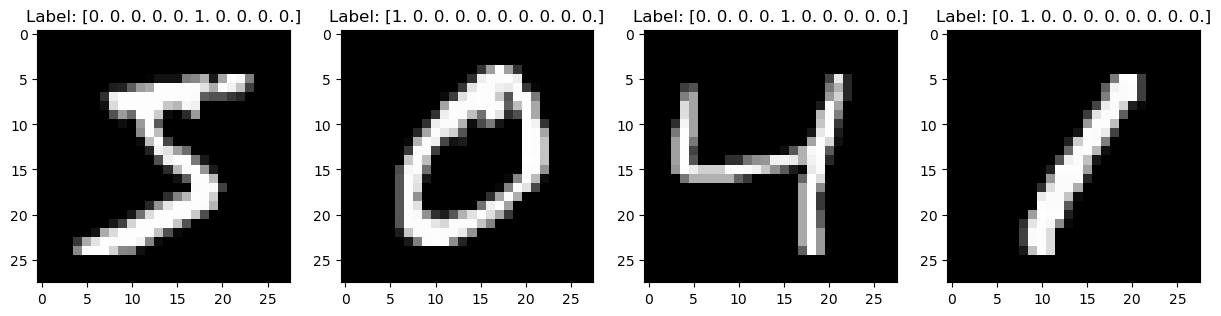

In [9]:
num_images = 4
fig,axes = plt.subplots(1,num_images,figsize=(15,10))
for image,label,ax in zip(X_train[:num_images],y_train[:num_images],axes):
    ax.imshow(image.reshape(28,28),cmap='gray',vmin=0,vmax=1.0)
    ax.set_title(f"Label: {label}")

In [10]:
model = MLP(X_train,Y_train,L=1,N_l=20)
model.train(batch_size=8,epochs=25,lr=1)

Epoch 1: loss = 1.619 | acc = 0.858 | train_time = 1.794
Epoch 2: loss = 1.546 | acc = 0.914 | train_time = 1.903
Epoch 3: loss = 1.534 | acc = 0.925 | train_time = 1.889
Epoch 4: loss = 1.528 | acc = 0.929 | train_time = 2.02
Epoch 5: loss = 1.524 | acc = 0.934 | train_time = 2.155
Epoch 6: loss = 1.521 | acc = 0.935 | train_time = 2.035
Epoch 7: loss = 1.518 | acc = 0.938 | train_time = 2.525
Epoch 8: loss = 1.516 | acc = 0.941 | train_time = 2.087
Epoch 9: loss = 1.514 | acc = 0.941 | train_time = 1.97
Epoch 10: loss = 1.513 | acc = 0.943 | train_time = 2.004
Epoch 11: loss = 1.511 | acc = 0.945 | train_time = 1.975
Epoch 12: loss = 1.511 | acc = 0.946 | train_time = 2.028
Epoch 13: loss = 1.51 | acc = 0.947 | train_time = 2.244
Epoch 14: loss = 1.509 | acc = 0.947 | train_time = 2.127
Epoch 15: loss = 1.508 | acc = 0.947 | train_time = 1.856
Epoch 16: loss = 1.507 | acc = 0.949 | train_time = 2.146
Epoch 17: loss = 1.506 | acc = 0.95 | train_time = 2.15
Epoch 18: loss = 1.505 | acc

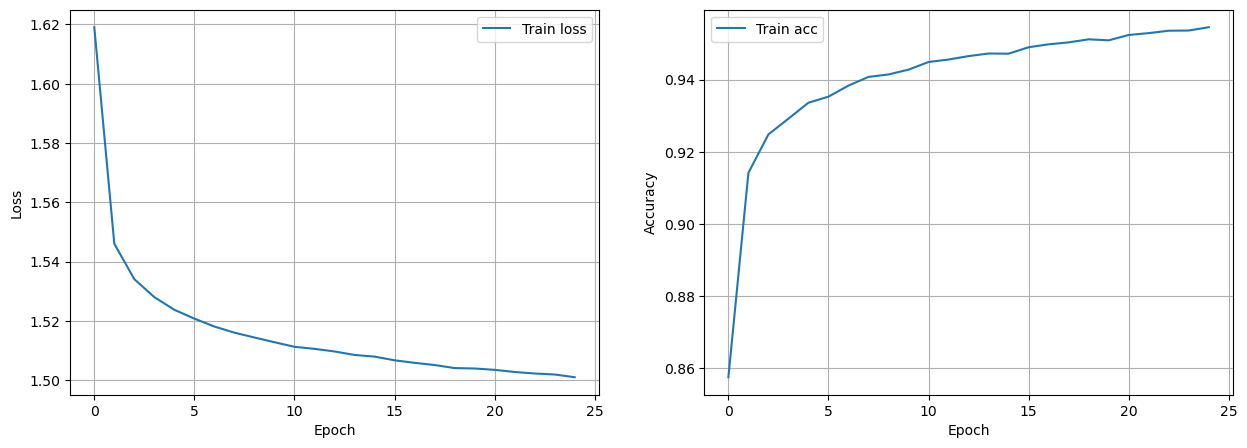

In [11]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(model.train_loss,label="Train loss")
ax[0].legend()
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid()

ax[1].plot(model.train_acc,label="Train acc")
ax[1].legend()
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].grid()

In [12]:
model.evaluate(X_test,y_test)

0.9349